In [1]:
# imports
import csv
import math
import random
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import NearestNeighbors
import sklearn.model_selection as ms
from sklearn.metrics import f1_score
from dateutil.parser import parse
from datetime import datetime
import statsmodels.api as sm
from scipy import stats
import fairlearn.moments as moments
import fairlearn.classred as red
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler
from statistics import mean, median, stdev
from matplotlib.ticker import FuncFormatter
from plotnine import *

# Part 1: Data Preparation

We'll begin by importing the data and doing some basic information extraction and cleaning. 
This helps prepare our dataset for model building later on.

The data file, whose contents are described in the provided file _Data Dictionary.xlsx_, is:

* `train.csv` - data on auto-loans, in comma-separated value (CSV) format

## Step 1.1 Importing CSV Data

The first task will be to import tabular data.

In [29]:
# load data
train_x = pd.read_csv("../Credit-Scoring/train.csv")
train_x = train_x.iloc[0:50000]

In [30]:
# observe what data looks like
train_x.head(10)

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-1984,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-1985,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-1985,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-1993,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-1977,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1
5,518279,54513,61900,89.66,67,22807,45,1501,08-09-1990,Self employed,...,0,0,1347,0,0,0,1yrs 9mon,2yrs 0mon,0,0
6,529269,46349,61500,76.42,67,22807,45,1502,01-06-1988,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
7,510278,43894,61900,71.89,67,22807,45,1501,04-10-1989,Salaried,...,0,0,0,0,0,0,0yrs 2mon,0yrs 2mon,0,0
8,490213,53713,61973,89.56,67,22807,45,1497,15-11-1991,Self employed,...,0,0,0,0,0,0,4yrs 8mon,4yrs 8mon,1,0
9,510980,52603,61300,86.95,67,22807,45,1492,01-06-1968,Salaried,...,0,0,2608,0,0,0,1yrs 7mon,1yrs 7mon,0,0


In [31]:
# Identify number of missing values in different columns
train_x.isnull().sum()

UNIQUEID                                  0
DISBURSED_AMOUNT                          0
ASSET_COST                                0
LTV                                       0
BRANCH_ID                                 0
SUPPLIER_ID                               0
MANUFACTURER_ID                           0
CURRENT_PINCODE_ID                        0
DATE_OF_BIRTH                             0
EMPLOYMENT_TYPE                        1946
DISBURSAL_DATE                            0
STATE_ID                                  0
EMPLOYEE_CODE_ID                          0
MOBILENO_AVL_FLAG                         0
AADHAR_FLAG                               0
PAN_FLAG                                  0
VOTERID_FLAG                              0
DRIVING_FLAG                              0
PASSPORT_FLAG                             0
PERFORM_CNS_SCORE                         0
PERFORM_CNS_SCORE_DESCRIPTION             0
PRI_NO_OF_ACCTS                           0
PRI_ACTIVE_ACCTS                

## Part 1.2 Handling Missing Data

Since our only missing data __'EMPLOYMENT_TYPE'__ is categorical, we assign a unique 'missing' label to rows missing that value.

In [32]:
# fill missing categorical variables with new label 'Missing'
categorical_missing_vars = ['EMPLOYMENT_TYPE']
for category in categorical_missing_vars:
    train_x[category] = train_x[category].fillna('Missing')

## Part 1.3 Wrangling Zip-Codes

Because there are so many values for __'CURRENT_PINCODE_ID'__, to ensure that enough samples belong to each category, we will bin them by dropping the first 2 digits, leaving only the area code.

In [33]:
train_x['CURRENT_PINCODE_ID'] = train_x['CURRENT_PINCODE_ID'].apply(lambda x: x//100)
train_x[['CURRENT_PINCODE_ID']].head()

,CURRENT_PINCODE_ID
0,14
1,15
2,14
3,15
4,14


## Part 1.4 Converting Birthdays to Age

To make __DATE_OF_BIRTH__ a useable numeric feature, we will convert birthdays to age in years

In [34]:
def age(x):
    birthday = parse(x)
    now = datetime.now()
    return (now - birthday).days // 365
train_x['DATE_OF_BIRTH'] = train_x['DATE_OF_BIRTH'].apply(age)
train_x['DATE_OF_BIRTH'].describe()

count    50000.00000
mean        34.75982
std          9.79690
min         18.00000
25%         27.00000
50%         33.00000
75%         42.00000
max         65.00000
Name: DATE_OF_BIRTH, dtype: float64

## Part 1.5 Parsing Months from Months & Years Strings

__AVERAGE_ACCT_AGE__ and __CREDIT_HISTORY_LENGTH__ were both in the form _4yrs 8mon to number_
We parse these strings and convert them to numeric months

In [35]:
toParse = ['AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH']

def monthsFromString(string):
    split = string.split('yrs')
    yearsToMonths = int(split[0]) * 12
    months = int(split[1].split(' ')[1].split('mon')[0])
    return yearsToMonths + months

for field in toParse:
    train_x[field] = train_x[field].apply(monthsFromString)

train_x['AVERAGE_ACCT_AGE'].describe()

count    50000.00000
mean         8.67770
std         14.85341
min          0.00000
25%          0.00000
50%          0.00000
75%         12.00000
max        191.00000
Name: AVERAGE_ACCT_AGE, dtype: float64

## Part 1.6 Converting Categorical Variables to One-hot Encodings

Categorical variables will be converted to one-hot encodings to allow for regression. 
The following were one-hot encoded:

__['BRANCH_ID', 'SUPPLIER_ID', 'MANUFACTURER_ID', 'STATE_ID', 'EMPLOYMENT_TYPE', 'STATE_ID', 'PERFORM_CNS_SCORE_DESCRIPTION']__

Some categorical variables were already one-hot encodeded:

__['AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG', 'DRIVING_FLAG', 'PASSPORT_FLAG']__

**Note: Although we would typically take this step, for computational efficiency we are excluding categorical variables for now**

In [36]:
# replace non-binary categorical variables with one-hot encodings
categorical_vars = ['BRANCH_ID', 'SUPPLIER_ID', 'MANUFACTURER_ID', 'STATE_ID', 'EMPLOYMENT_TYPE', 'PERFORM_CNS_SCORE_DESCRIPTION', 'CURRENT_PINCODE_ID']
# for category in categorical_vars:
#     train_x[category] = train_x[category].astype(str)
#     train_x = pd.concat([train_x, pd.get_dummies(train_x[category], drop_first=True)], axis=1)
#     train_x.drop([category], axis=1, inplace=True)
train_x.shape
train_x = train_x.drop(columns=categorical_vars)



## Part 1.7 Non-Predictive Attributes Dropped

We finally drop columns that won't be predictive or take on only one value, including:

__['DISBURSAL_DATE', 'EMPLOYEE_CODE_ID', 'MOBILENO_AVL_FLAG', 'UNIQUEID', 'EMPLOYEE_CODE_ID']__

In [37]:
cols_to_drop = ['DISBURSAL_DATE', 'MOBILENO_AVL_FLAG', 'UNIQUEID', 'EMPLOYEE_CODE_ID']
train_x = train_x.drop(columns = cols_to_drop)

## Part 1.8 Adding a Protected Attribute

As there were no protected attributes in the dataset, we synthetically generate biased __GENDER__ values.

In [38]:
def biasedGender(row):
    # 1 is female, 0 is male
    # 80% chance of 1 if default, 43% chance of 1 otherwise
    if row.LOAN_DEFAULT == 1:
        if random.randint(1, 101) > 80:
            return 0
        else:
            return 1
    else:
        if random.randint(1, 101) > 43:
            return 0
        else:
            return 1

train_x['IS_FEMALE'] = train_x.apply(biasedGender, axis = 1)
train_x[['IS_FEMALE']].head()

,IS_FEMALE
0,0
1,1
2,1
3,1
4,1


## 1.9 Making it an Alternative Credit Score

By adding mock transaction data, we show how a player in the financial system with data 
on users' transactions could improve their prediction accuracy with regards to default rates.

We will model transaction data using RFM--Recency, Frequency, and Monetary Value--which is a popular method for measuring customer value.

In particular, we'll create mock data for (1) whether or not someone was late on last month's payment, (2) how frequently they make late payments, and (3) the average amount of money in those payments

In [39]:
def biasedRecency(row):
    # 80% chance of 1 if default, 43% chance of 1 otherwise
    if row.LOAN_DEFAULT == 1:
        if random.randint(1, 101) > 80:
            return 0
        else:
            return 1
    else:
        if random.randint(1, 101) > 43:
            return 0
        else:
            return 1
        
def biasedFrequency(row):
    if row.LOAN_DEFAULT == 1:
        maxFreq = 0
        for i in range(5):
            maxFreq = max(maxFreq, random.uniform(0, 0.25))
        return maxFreq
    else:
        return random.uniform(0, 0.25)
    
def monetaryValue(row):
    return random.paretovariate(.1)*1000

train_x['RECENCY'] = train_x.apply(biasedRecency, axis = 1)
train_x['FREQUENCY'] = train_x.apply(biasedFrequency, axis = 1)
train_x['MONETARY_VALUE'] = train_x.apply(monetaryValue, axis = 1)

## 1.10 Feature Selection

We want to include only features that strongly correlate with loan default.
We can identify them using Pearson Correlation

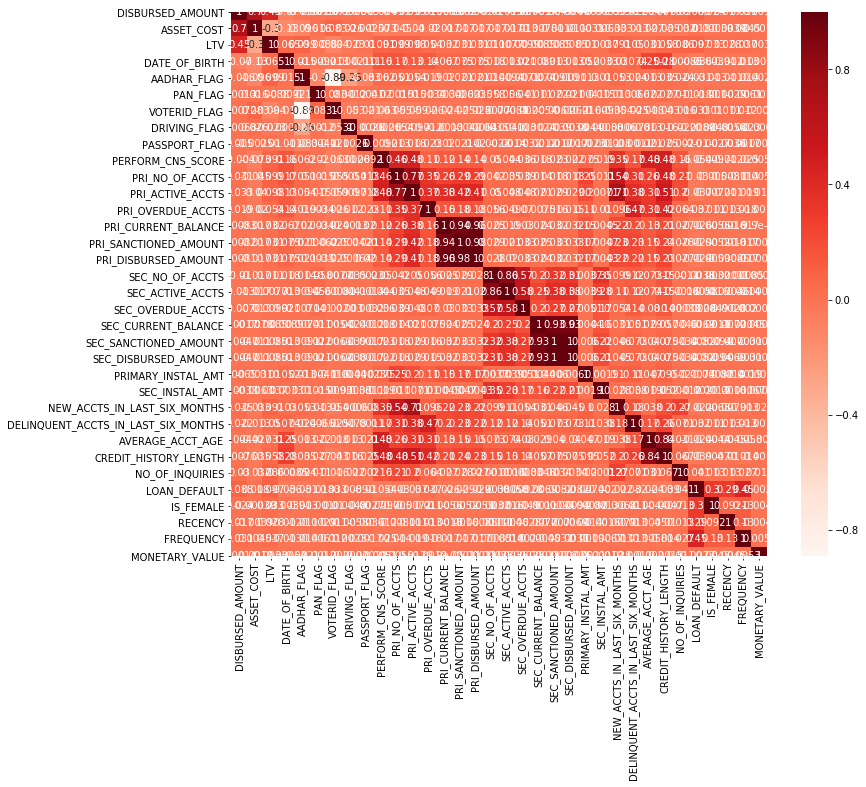

In [40]:
plt.figure(figsize=(12,10))
cor = train_x.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [41]:
cor_target = abs(cor["LOAN_DEFAULT"])
relevant_features = cor_target[cor_target>0.05]
relevant_features_list = list(relevant_features.index)
print(relevant_features)
train_x = train_x[relevant_features_list]
for relevant_feature in relevant_features_list:
    for relevant_feature2 in relevant_features_list:
        if relevant_feature != relevant_feature2:
            corr = train_x[[relevant_feature, relevant_feature2]].corr()[relevant_feature][relevant_feature2]
            if corr > 0.5:
                print(f'Feature 1:{relevant_feature}, Feature 2:{relevant_feature2}, Correlation:{corr}')

DISBURSED_AMOUNT     0.087519
LTV                  0.097244
PERFORM_CNS_SCORE    0.054284
LOAN_DEFAULT         1.000000
IS_FEMALE            0.299146
RECENCY              0.293736
FREQUENCY            0.452223
Name: LOAN_DEFAULT, dtype: float64


In [42]:
# remove features that strongly correlate with one another
# correlated = ['PERFORM_CNS_SCORE', 'CREDIT_HISTORY_LENGTH']
correlated = []
train_x = train_x.drop(columns=correlated)

In [43]:
# move target to a separate column, and drop it from x variables
train_y = train_x['LOAN_DEFAULT']
train_x = train_x.drop(columns="LOAN_DEFAULT")

In [44]:
train_y.head(10)

0    0
1    1
2    0
3    1
4    1
5    0
6    0
7    0
8    0
9    0
Name: LOAN_DEFAULT, dtype: int64

In [45]:
train_y.describe()

count    50000.000000
mean         0.202740
std          0.402044
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: LOAN_DEFAULT, dtype: float64

In [46]:
# calculate p-values of remaining features
X = sm.add_constant(train_x)
model = sm.Logit(train_y, X)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.299277
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           LOAN_DEFAULT   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49993
Method:                           MLE   Df Model:                            6
Date:                Fri, 02 Aug 2019   Pseudo R-squ.:                  0.4064
Time:                        22:02:30   Log-Likelihood:                -14964.
converged:                       True   LL-Null:                       -25209.
                                        LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -10.0013      0.136    -73.620      0.000     -10.268      -9.735
DISBURSED_AMOUNT   1.273e-05   1.34e-06      9.505      0.000    1.01e-05    1.53e-05
LTV                   0.0202      0.001     14.000      0.000       0.017       0.023
PERFORM_CNS_SCORE    -0.0005    4.4e-05    -11.801      0.000      -0.001      -0.000
IS_FEMALE             1.6920      0.032     53.234      0.000       1.630       1.754
RECENCY               1.6736      0.032     52.761      0.000       1.611       1.736
FREQUENCY            25.4173      0.332     76.620      0.000      24.767      26.067
=====================================================================================
"""

In [47]:
# remove columns with p-values great than 0.05
# lowPValueColumns = ['VOTERID_FLAG', 'AVERAGE_ACCT_AGE']
lowPValueColumns = []
train_x = train_x.drop(columns=lowPValueColumns)

In [48]:
# visualize prepared data
print(train_x.shape)
train_x.head(10)

(50000, 6)


,DISBURSED_AMOUNT,LTV,PERFORM_CNS_SCORE,IS_FEMALE,RECENCY,FREQUENCY
0,50578,89.55,0,0,0,0.146297
1,47145,73.23,598,1,0,0.096977
2,53278,89.63,0,1,0,0.033635
3,57513,88.48,305,1,1,0.151648
4,52378,88.39,0,1,1,0.215690
5,54513,89.66,825,0,1,0.239796
6,46349,76.42,0,1,0,0.127615
7,43894,71.89,17,0,0,0.177172
8,53713,89.56,718,1,1,0.034151
9,52603,86.95,818,1,0,0.002082


# Part 2: Unfair Model Building



## 2.1 Train/Test Split

We choose an 80-20 Train-Test split, randomly done. We also create data frames without gender, which we will use for training

In [49]:
# train/test split
X_train, X_test, y_train, y_test = ms.train_test_split(train_x, train_y, test_size=0.2, random_state = 195)
print(X_train.shape)
print(X_test.shape)
X_train_no_gender = X_train.drop(columns=['IS_FEMALE'])
X_test_no_gender = X_test.drop(columns=['IS_FEMALE'])

(40000, 6)
(10000, 6)


## 2.2 Applying Scaling

Scaling variables is used to normalize values, and makes interpreting feature importance easier

In [50]:
scaler = StandardScaler()
X_train_no_gender[X_train_no_gender.columns] = scaler.fit_transform(X_train_no_gender[X_train_no_gender.columns])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## 2.3 Applying Simple Models to Biased Data

Logistic Regression, Gradient Boosting, and Support Vector Machines as baseline models

In [51]:
log = LogisticRegression(solver='liblinear', max_iter=100, penalty='l1')
reg = log.fit(X_train_no_gender, y_train)
print(f'Train accuracy: {reg.score(X_train_no_gender, y_train)}, Test accuracy: {reg.score(X_test_no_gender, y_test)}')
print(f'Train f1: {f1_score(y_train, reg.predict(X_train_no_gender))}, Test f1: {f1_score(y_test, reg.predict(X_test_no_gender))}')



Train accuracy: 0.844675, Test accuracy: 0.2091
Train f1: 0.5651900062985513, Test f1: 0.3458770986684311


In [52]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_no_gender, y_train)
print(f'Train accuracy: {gbc.score(X_train_no_gender, y_train)}, Test accuracy: {gbc.score(X_test_no_gender, y_test)}')
print(f'Train f1: {f1_score(y_train, gbc.predict(X_train_no_gender))}, Test f1: {f1_score(y_test, gbc.predict(X_test_no_gender))}')



Train accuracy: 0.849, Test accuracy: 0.7909
Train f1: 0.5822382072209158, Test f1: 0.0


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf', 
            probability=True,
            gamma='auto')
svc.fit(X_train_no_gender, y_train)
print(f'Train accuracy: {svc.score(X_train_no_gender, y_train)}, Test accuracy: {svc.score(X_test_no_gender, y_test)}')
print(f'Train f1: {f1_score(y_train, svc.predict(X_train_no_gender))}, Test f1: {f1_score(y_test, svc.predict(X_test_no_gender))}')



# Part 3: Creating a Score and Visualizing Bias

## 3.1 Converting Probabilities to Scores

We use credit scoring convention -- points to double the odds -- as our method of converting probabilities to credit scores. We set 1:2 Odds of defaulting to correspond to a score of 600. From this point, every doubling of the odds leads to a 50 point increase, ex. 1/4 odds (or a 25% chance) would correspond to a score of 650.

In [25]:
def scoreFromOdds(odds):
    factor = 50/math.log(2)
    offset = 600 - factor*math.log(2)
    score = offset + factor*math.log(odds)
    return score

model = reg

probs = [prob[1] for prob in model.predict_proba(X_train_no_gender)]
scores = [scoreFromOdds(1/prob) for prob in probs]
numToDisplay = 10

for (prob, score) in zip(probs[:numToDisplay], scores[:numToDisplay]):
    print(f'Probability of default: {prob}, Score: {score}')

Probability of default: 0.2900753705095136, Score: 639.2750144681308
Probability of default: 0.01423365319254957, Score: 856.7275099992972
Probability of default: 0.08830825731707366, Score: 725.0653922760121
Probability of default: 0.07223916210898304, Score: 739.553751522926
Probability of default: 0.11190619686320245, Score: 707.981908319058
Probability of default: 0.374020488776954, Score: 620.940539601387
Probability of default: 0.7210237744102528, Score: 573.5940632233317
Probability of default: 0.7608135936777586, Score: 569.719253570335
Probability of default: 0.06334329229478934, Score: 749.0332167883125
Probability of default: 0.6696884677041792, Score: 578.921898519649


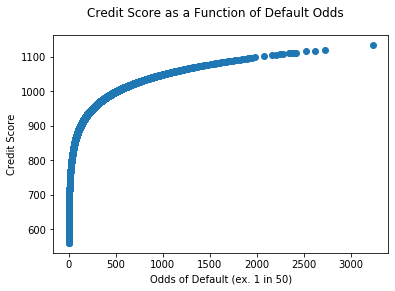

In [26]:
scatter = plt.scatter([1/prob for prob in probs], scores)
y = plt.ylabel('Credit Score')
x = plt.xlabel('Odds of Default (ex. 1 in 50)')
title = plt.suptitle('Credit Score as a Function of Default Odds')

In [27]:
X_train['CREDIT_SCORE'] = scores
X_train.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,DISBURSED_AMOUNT,LTV,PERFORM_CNS_SCORE,IS_FEMALE,RECENCY,FREQUENCY,CREDIT_SCORE
28049,-1.401389,-1.017113,-0.842595,0.998042,-1.002764,1.434851,639.275014
23092,-0.202624,0.689754,-0.842595,0.998042,-1.002764,-0.666478,856.727510
17562,0.226826,0.330235,1.427954,-1.001962,-1.002764,0.600969,725.065392
25788,-0.197403,-0.460028,0.988493,0.998042,-1.002764,0.557479,739.553752
34952,-0.395471,0.420115,-0.842595,0.998042,0.997244,-0.350271,707.981908


Number of Men: 0, Number of Women: 0


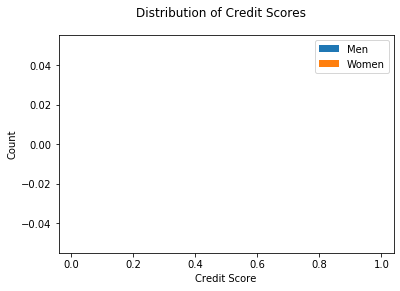

In [28]:
men_scores = X_train[X_train['IS_FEMALE'] == 0]['CREDIT_SCORE'].values
women_scores = X_train[X_train['IS_FEMALE'] == 1]['CREDIT_SCORE'].values
hist = plt.hist([men_scores, women_scores], label=['Men', 'Women'])
y = plt.ylabel('Count')
x = plt.xlabel('Credit Score')
plt.legend(loc='upper right')
title = plt.suptitle('Distribution of Credit Scores')
print(f'Number of Men: {len(men_scores)}, Number of Women: {len(women_scores)}')

In [ ]:
freqPlot = ggplot(X_train[:200], aes(x = 'FREQUENCY', y = 'CREDIT_SCORE', color = 'IS_FEMALE')) + geom_point() + ggtitle("Frequency of Late Payments vs Credit Score")
disbursedPlot = ggplot(X_train[:200], aes(x = 'DISBURSED_AMOUNT', y = 'CREDIT_SCORE', color = 'IS_FEMALE')) + geom_point() + ggtitle("Disbursed Amount vs Credit Score")

freqPlot
# disbursedPlot


## Part 4: Fair Model Building


In [ ]:
log = LogisticRegression(solver='liblinear', max_iter=100, penalty='l1')
res_tuple = red.expgrad(X_train_no_gender, X_train['IS_FEMALE'], y_train, log,
                                cons=moments.DP(), eps=0.1)

In [ ]:
res = res_tuple._asdict()
Q = res["best_classifier"]
res["n_classifiers"] = len(res["classifiers"])

disp = moments.DP()
disp.init(X_train_no_gender, X_train['IS_FEMALE'], y_train)

error = moments.MisclassError()
error.init(X_train_no_gender, X_train['IS_FEMALE'], y_train)

res["disp"] = disp.gamma(Q).max()
res["error"] = error.gamma(Q)[0]

print(res['error'])

In [ ]:
# print(f'Train accuracy: {res.score(X_train, y_train)}, Test accuracy: {res.score(X_test, y_test)}')
# print(f'Train f1: {f1_score(y_train, res.predict(X_train))}, Test f1: {f1_score(y_test, res.predict(X_test))}')
print([name for name in res])
print(res['error'])
print(res['weights'])
# print(res['best_classifier'](X_train_no_gender))
# print(res['n_classifiers'])
# print(res['weights'])
# print(res['classifiers'][7])
def getProb(df):
    oddsOfDefault = np.zeros(df.shape[0])
    for i in range(res['n_classifiers']):
        if res['weights'][i] > 0:
            weight = res['weights'][i]
            probs = res['classifiers'][i].predict_proba(df)
            oddsOfDefault = [odds + weight*prob[1] for odds, prob in zip(oddsOfDefault, probs)]
    return oddsOfDefault

fairProbs = getProb(X_train_no_gender)

In [ ]:
fairScores = [scoreFromOdds(1/prob) for prob in fairProbs]
X_train['FAIR_CREDIT_SCORE'] = fairScores
X_train.head()

In [ ]:
def probToLabel(prob):
    if prob > 0.5:
        return 1
    else:
        return 0

def accuracy(preds, trues):
    correct = [pred == true for pred, true in zip(preds, trues)]
    correctCount = correct.count(True)
    return correctCount/len(preds)

fairPred = [probToLabel(prob) for prob in fairProbs]
fairTestProbs = getProb(X_test_no_gender)
fairTestPred = [probToLabel(prob) for prob in fairTestProbs]

print(f'Train accuracy: {accuracy(fairPred, y_train)}, Test accuracy: {accuracy(fairTestPred, y_test)}')

In [ ]:
X_train['CREDIT_SCORE'] = scores
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)

men_scores = X_train[X_train['IS_FEMALE'] == 0]['CREDIT_SCORE'].values
women_scores = X_train[X_train['IS_FEMALE'] == 1]['CREDIT_SCORE'].values
hist = plt.hist([men_scores, women_scores], label=['Men', 'Women'])
y = plt.ylabel('Count')
x = plt.xlabel('Credit Score')
plt.legend(loc='upper right')
# title = plt.suptitle('Distribution of Credit Scores')

plt.subplot(1, 2, 2)

men_scores = X_train[X_train['IS_FEMALE'] == 0]['FAIR_CREDIT_SCORE'].values
women_scores = X_train[X_train['IS_FEMALE'] == 1]['FAIR_CREDIT_SCORE'].values
hist = plt.hist([men_scores, women_scores], label=['Men', 'Women'])
y = plt.ylabel('Count')
x = plt.xlabel('Fair Credit Score')
plt.legend(loc='upper right')
title = plt.suptitle('Distribution of Credit Scores: Before and After')
title.set_position([.5, 1.05])
print(f'Number of Men: {len(men_scores)}, Number of Women: {len(women_scores)}')
plt.tight_layout()

## Part 5: Visualizing Fairness

In [ ]:
def getMatchingPairsDiff(men, women, full, offset=1, scaler=True):
    men_x = men.values
    women_x = women.values
    if scaler == True:
        scaler = StandardScaler()
    if scaler:
        scaler.fit(men_x)
        men_x = scaler.transform(men_x)
        women_x = scaler.transform(women_x)

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(men_x)
    distances, indices = nbrs.kneighbors(women_x)
    indices = indices.reshape(indices.shape[0])
    diffs = []
    rows, cols = women.shape
    for i in range(rows):
        if i < 10:
            print(f'index: {i}, Woman Score is: {women.iloc[i, cols-offset]}, Man Score is: {men.iloc[indices[i], cols-1]}, Diff: {women.iloc[i, cols-offset] - men.iloc[indices[i], cols-offset]}')
        diffs.append(women.iloc[i, cols-offset] - men.iloc[indices[i], cols-offset])
    return diffs

men = X_train[X_train['IS_FEMALE'] == 0]
women = X_train[X_train['IS_FEMALE'] == 1]
diffs = getMatchingPairsDiff(men, women, X_train)
diffplot = plt.plot(diffs)

In [ ]:
print(f'Mean Score: {sum(scores)/len(scores)}, Mean Absolute Diff: {sum(diffs)/len(diffs)}')

In [ ]:
diffs = getMatchingPairsDiff(men, women, X_train, offset=2)
diffplot = plt.plot(diffs)

In [ ]:
print(f'Mean Score: {sum(scores)/len(scores)}, Mean Absolute Diff: {sum(diffs)/len(diffs)}')

## Part 6: A New Fairness Library (AIF360)

In [ ]:
import sys
sys.path.append("../")
import numpy as np

In [ ]:
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from collections import OrderedDict
from aif360.metrics import ClassificationMetric


In [ ]:
dataset_orig = StandardDataset(df=train_x, label_name='LOAN_DEFAULT',  favorable_classes=[0], protected_attribute_names=['IS_FEMALE'], privileged_classes=[lambda x: x == 1])

dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

In [ ]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

In [ ]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [ ]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

In [ ]:
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression(solver='lbfgs')
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

In [ ]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [ ]:
probs = [prob[1] for prob in lmod.predict_proba(X_train)]
scores = [scoreFromOdds(1/prob) for prob in probs]

X_train['CREDIT_SCORE'] = scores

men_scores = X_train[X_train['IS_FEMALE'] == 0]['CREDIT_SCORE'].values
women_scores = X_train[X_train['IS_FEMALE'] == 1]['CREDIT_SCORE'].values
hist = plt.hist([men_scores, women_scores], label=['Men', 'Women'])
y = plt.ylabel('Count')
x = plt.xlabel('Credit Score')
plt.legend(loc='upper right')
title = plt.suptitle('Distribution of Credit Scores')
print(f'Number of Men: {len(men_scores)}, Number of Women: {len(women_scores)}')


In [ ]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

In [ ]:
def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [ ]:
print("#### Predictions from original testing data")
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

In [ ]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression(solver='lbfgs')
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

In [ ]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [ ]:
print("#### Predictions from transformed testing data")
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])